# Analyse reindexation from ABES - April 2023

# Set project

### Packages

In [1]:
# Import librairies and useful fonctions

from utils_project import *
from utils_metrics import *
from utils_visualization import *

In [2]:
# Parametres graphiques
%matplotlib inline

# Import data

In [3]:
# Original dataset
rameau_file = "rameau_Tf_Td.csv"
sudoc = "working_data_sans_dewey.pkl"
reindex_file = "reindexation_final_juin2023.csv"

In [4]:
#Import data
reindex = pd.read_csv(os.path.join(data_path, reindex_file), index_col=0)
print(reindex.shape)
print("Colonnes: ", reindex.columns)

(100, 16)
Colonnes:  Index(['N°ordre', 'PPN', 'TITRE', 'RESUME', 'INDEX_UNI_AFE', 'INDEX_AFE',
       'INDEX_UNI_MCR', 'INDEX_MCR', 'INDEX_UNI_JMF', 'INDEX_JMF',
       'INDEX_UNI_LPL', 'INDEX_LPL', 'INDEX_UNI_LJZ', 'INDEX_LJZ',
       'INDEX_UNI_MPD', 'INDEX_MPD'],
      dtype='object')


In [5]:
# Import SUDOC
sudoc_file = pd.read_pickle(os.path.join(data_path, sudoc))
print(sudoc_file.shape)

(154447, 10)


In [6]:
# Import rameau list
ram = pd.read_csv(os.path.join(data_path, rameau_file), index_col=0)
print("Nombre de notices différentes: ", ram.shape[0])
ram.head(10)

Nombre de notices différentes:  103628


PPN                                        NOM   
0  157992527                                     Kirp?n  \
1  110140494                        Militaires artistes   
2  028492161                         Militaires romains   
3  028521757                       Militaires prussiens   
4  029895561                                 Sa-skya-pa   
5  031875459                     Militaires réunionnais   
6  032370083  Construction à l'épreuve de la sécheresse   
7  032878117                      Missionnaires suisses   
8  034423982                       Militaires ivoiriens   
9  034686940                            Outils à métaux   

                              URI  
0  https://www.idref.fr/157992527  
1  https://www.idref.fr/110140494  
2  https://www.idref.fr/028492161  
3  https://www.idref.fr/028521757  
4  https://www.idref.fr/029895561  
5  https://www.idref.fr/031875459  
6  https://www.idref.fr/032370083  
7  https://www.idref.fr/032878117  
8  https://www.idref.fr/034423982  
9  https://www.idref.fr/034686940

## Merge SUDOC and reindexation files

In [7]:
# Defined columns to merge
cols_to_use = reindex.columns.difference(sudoc_file.columns).tolist()
cols_to_use.append("PPN")


In [8]:
df = sudoc_file[["PPN", "DESCR", "RAMEAU_CHECKED", "rameau_concepts", "rameau_chaines_index"]].merge(reindex[cols_to_use], on="PPN", how="inner")
print(df.shape)
df.columns

(100, 18)


Index(['PPN', 'DESCR', 'RAMEAU_CHECKED', 'rameau_concepts',
       'rameau_chaines_index', 'INDEX_AFE', 'INDEX_JMF', 'INDEX_LJZ',
       'INDEX_LPL', 'INDEX_MCR', 'INDEX_MPD', 'INDEX_UNI_AFE', 'INDEX_UNI_JMF',
       'INDEX_UNI_LJZ', 'INDEX_UNI_LPL', 'INDEX_UNI_MCR', 'INDEX_UNI_MPD',
       'N°ordre'],
      dtype='object')

# Analyse RAMEAU concepts

In [9]:
index_columns = [
    'INDEX_AFE', 'INDEX_MCR', 'INDEX_JMF',
    'INDEX_LPL', 'INDEX_LJZ','INDEX_MPD'
]

## Get all concepts

In [10]:
df.columns

Index(['PPN', 'DESCR', 'RAMEAU_CHECKED', 'rameau_concepts',
       'rameau_chaines_index', 'INDEX_AFE', 'INDEX_JMF', 'INDEX_LJZ',
       'INDEX_LPL', 'INDEX_MCR', 'INDEX_MPD', 'INDEX_UNI_AFE', 'INDEX_UNI_JMF',
       'INDEX_UNI_LJZ', 'INDEX_UNI_LPL', 'INDEX_UNI_MCR', 'INDEX_UNI_MPD',
       'N°ordre'],
      dtype='object')

In [11]:
# Mettre à plat TOUS les mots clé
pattern = r';;\s*(?![^()$]*\))| -- |-- | --|--| - '

for col in index_columns:
    name = col.split("_")[1]
    print("Dealing with: ", name)
    new_col = str('rameau_concept_' + name)
    df[new_col] = df[col].apply(lambda x: re.split(pattern, str(x)))


Dealing with:  AFE
Dealing with:  MCR
Dealing with:  JMF
Dealing with:  LPL
Dealing with:  LJZ
Dealing with:  MPD


## Format data

In [12]:
col_to_keep = ["PPN", "rameau_concepts", "rameau_concept_AFE",
               "rameau_concept_MCR", "rameau_concept_JMF",
                "rameau_concept_LPL", "rameau_concept_LJZ", "rameau_concept_MPD"]
df_pivot = pd.melt(df[col_to_keep], id_vars=["PPN"])
df_pivot

PPN            variable   
0    000308838     rameau_concepts  \
1    00094758X     rameau_concepts   
2    003632806     rameau_concepts   
3    047450037     rameau_concepts   
4    05224170X     rameau_concepts   
..         ...                 ...   
695  266197809  rameau_concept_MPD   
696  26753177X  rameau_concept_MPD   
697  267884575  rameau_concept_MPD   
698  268799458  rameau_concept_MPD   
699  268924759  rameau_concept_MPD   

                                                 value  
0    [Bureaucratie, Classes dirigeantes, Classes di...  
1    [Dollar américain, Finances internationales, P...  
2              [Intellectuels, Intellectuels français]  
3                                         [Bouddhisme]  
4    [Mathématiques, Étude et enseignement, Mathéma...  
..                                                 ...  
695  [Féodalité, Histoire, Valence-en-Brie (Seine-e...  
696  [Société numérique, Algorithmes, Utilisation, ...  
697  [Capitalisme, Critique et interprétation, Dési...  
698                                  [Co-enseignement]  
699                            [Jardinage d'intérieur]  

[700 rows x 3 columns]

In [13]:
labels=df_pivot["value"]
labels

0      [Bureaucratie, Classes dirigeantes, Classes di...
1      [Dollar américain, Finances internationales, P...
2                [Intellectuels, Intellectuels français]
3                                           [Bouddhisme]
4      [Mathématiques, Étude et enseignement, Mathéma...
                             ...                        
695    [Féodalité, Histoire, Valence-en-Brie (Seine-e...
696    [Société numérique, Algorithmes, Utilisation, ...
697    [Capitalisme, Critique et interprétation, Dési...
698                                    [Co-enseignement]
699                              [Jardinage d'intérieur]
Name: value, Length: 700, dtype: object

In [14]:
keywords = flatten(labels)
print(f"Le dataset contient {len(set(keywords))} concepts RAMEAU differents")

Le dataset contient 931 concepts RAMEAU differents


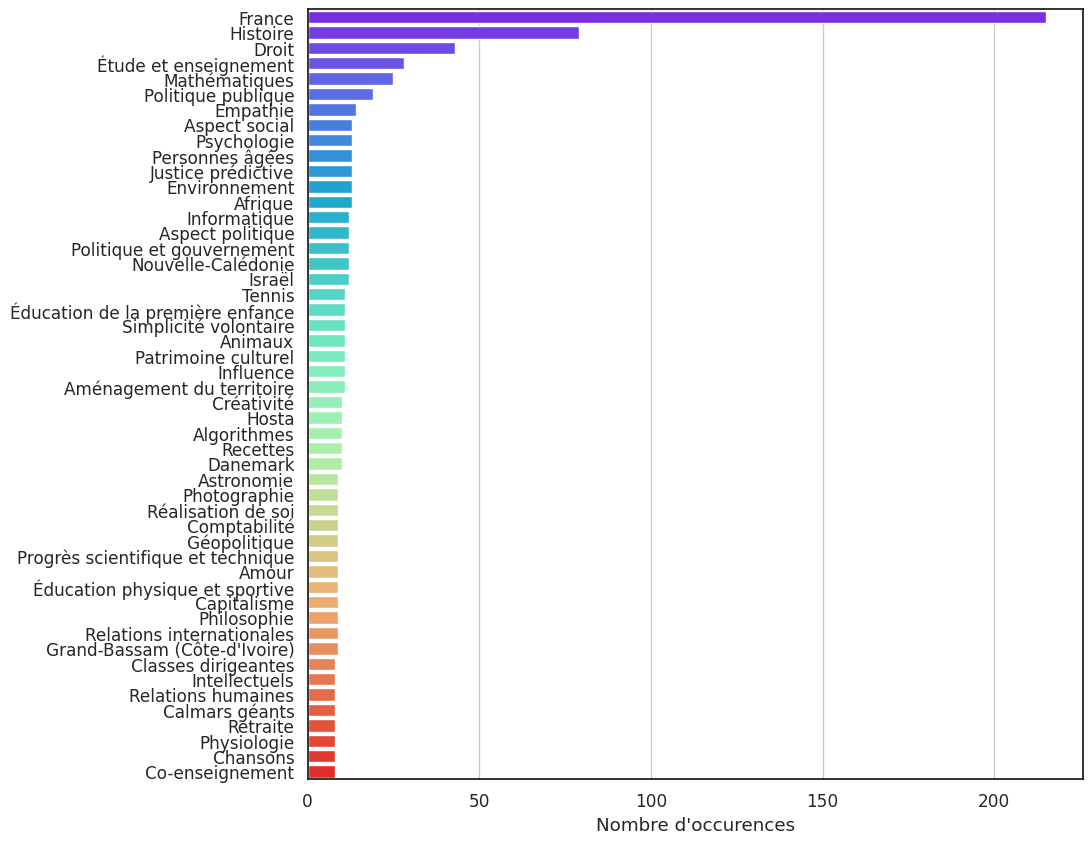

In [15]:
plot_barplot_of_tags(
    keywords,
    nb_of_tags=50,
    xlabel="Nombre d'occurences",
    ylabel="",
    figsave="barplot_concept_reindexation.png",
    figsize=(10, 10),
    palette="rainbow",
    orient="h",
)

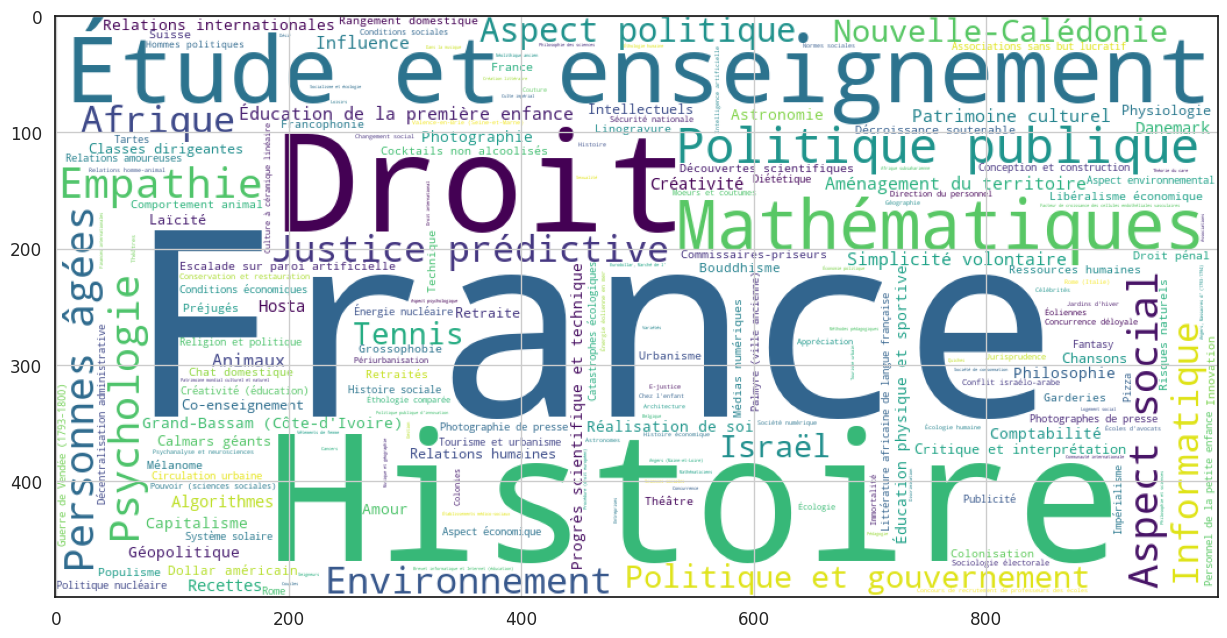

In [16]:
plot_wordcloud(
    keywords,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_reindexation.png",
)

In [17]:
all_possible_concepts =ram["NOM"].to_list()
print(f"Le dictionnaire RAMEAU contient {len(set(all_possible_concepts))} concepts differents")

Le dictionnaire RAMEAU contient 103021 concepts differents


# Multilabel classification

## By Concepts

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb

MultiLabelBinarizer()

In [19]:
# Binarization
concepts = mlb.fit_transform([all_possible_concepts]) # all_concepts
concepts

array([[1, 1, 1, ..., 1, 1, 1]])

In [20]:
# Verification que l'on a bien encodé tous les concepts possibles
len(concepts[0])

103021

In [21]:
# Veridication de l'encoage
mlb.classes_

array(['!Xóõ (langue)',
       '"Sprach- und Sachatlas Italiens und der Südschweiz"',
       '"Taalatlas van Noord- en Zuid-Nederland"', ..., 'Ḥawfi', 'Ṭhumrī',
       'Ṭār (tambour), Musique de'], dtype=object)

In [22]:
# Binarisation des concepts
sudoc = mlb.transform(df["rameau_concepts"])
afe = mlb.transform(df["rameau_concept_AFE"])
mcr = mlb.transform(df["rameau_concept_MCR"])
jmf = mlb.transform(df["rameau_concept_JMF"])
lpl = mlb.transform(df["rameau_concept_LPL"])
ljz = mlb.transform(df["rameau_concept_LJZ"])
mpd = mlb.transform(df["rameau_concept_MPD"])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['1789-1799 (Révolution)', '17e siècle', '1800-….', '1945-….', '1958-.... (5e République)', '19e siècle', '2000-....', '2000-….', '20e siècle', 'Afrique', 'Afrique subsaharienne', 'Angers (Maine-et-Loire)', 'Aspect psychologique', 'Belgique', 'Brevet Informatique et Internet (pédagogie)', 'Cancers', 'Colombelles (Calvados)', 'Colonialisme et ethnologie', 'Construction et conception', 'Contrat Social', 'Danemark', 'France', 'Grand-Bassam', 'Géants du web', 'Histoire ', 'Israël', 'Littérature post-coloniale', 'Mythes', 'Méthodes pédagogiques', 'Nouvelle-Calédonie', 'Palmyre (ville ancienne)', 'Performances (sport)', 'Personnel de la santé publique', 'Pratiques sexuelles', 'Projets urbains', 'Rome (Italie)', 'Suisse', 'Suède', 'Valence-en-Brie (Seine-et-Marne)', 'Éco-anxiété ', 'Écrivains africains de la langue française', 'États-Unis', "Études d'impact"

In [23]:
from itertools import combinations

index_name = ["sudoc", "afe", "mcr", "jmf", "lpl", "ljz", "mpd"]
concept_list = [sudoc, afe, mcr, jmf, lpl, ljz, mpd]
results = dict()

for names, concept in zip(list(combinations(index_name, 2)), list(combinations(concept_list, 2))):
    print(f"comparing {names[0]} and  {names[1]}")
    name = str(names[0] + '-' + names[1])
    results[name] = label_metrics_report("reindexation_concepts", y_true=concept[0], y_pred=concept[1], zero_division=0)

comparing sudoc and  afe


comparing sudoc and  mcr
comparing sudoc and  jmf
comparing sudoc and  lpl
comparing sudoc and  ljz
comparing sudoc and  mpd
comparing afe and  mcr
comparing afe and  jmf
comparing afe and  lpl
comparing afe and  ljz
comparing afe and  mpd
comparing mcr and  jmf
comparing mcr and  lpl
comparing mcr and  ljz
comparing mcr and  mpd
comparing jmf and  lpl
comparing jmf and  ljz
comparing jmf and  mpd
comparing lpl and  ljz
comparing lpl and  mpd
comparing ljz and  mpd


### Dataframe of results

In [24]:
result_df = pd.DataFrame(results).T
result_df.head(3)

Hamming Loss Brier Loss Accuracy Precision - Macro Recall - Macro   
sudoc-afe     0.000033        NaN     0.06          0.000837       0.000863  \
sudoc-mcr     0.000038        NaN     0.04          0.000718       0.000714   
sudoc-jmf      0.00004        NaN     0.03          0.000769       0.000773   

          F1_Score - Macro Jaccard - Macro Precision - Weighted   
sudoc-afe          0.00084        0.000815              0.36398  \
sudoc-mcr         0.000705        0.000677             0.330403   
sudoc-jmf         0.000761        0.000744              0.33128   

          Recall - Weighted F1_Score - Weighted Jaccard - Weighted   
sudoc-afe          0.369963            0.362118           0.343036  \
sudoc-mcr          0.315018            0.315629           0.294959   
sudoc-jmf          0.322344             0.31974           0.305229   

          Precision - Sample Recall - Sample F1_Score - Sample   
sudoc-afe              0.426         0.45244          0.394806  \
sudoc-mcr              0.339        0.402607          0.331828   
sudoc-jmf           0.314667        0.372179          0.308209   

          Jaccard - Sample                                          Precision   
sudoc-afe         0.286881  {'Macro': 0.0008367226099533105, 'Micro': 0.37...  \
sudoc-mcr         0.233373  {'Macro': 0.0007176530351417024, 'Micro': 0.30...   
sudoc-jmf         0.216067  {'Macro': 0.0007685988117162343, 'Micro': 0.28...   

                                                      Recall   
sudoc-afe  {'Macro': 0.0008632081947231285, 'Micro': 0.36...  \
sudoc-mcr  {'Macro': 0.0007143712262086187, 'Micro': 0.31...   
sudoc-jmf  {'Macro': 0.0007728428924107473, 'Micro': 0.32...   

                                                  F1-measure   
sudoc-afe  {'Macro': 0.000839715527254961, 'Micro': 0.374...  \
sudoc-mcr  {'Macro': 0.0007048185429292193, 'Micro': 0.30...   
sudoc-jmf  {'Macro': 0.0007613873762523066, 'Micro': 0.29...   

                                                     Jaccard  
sudoc-afe  {'Macro': 0.0008146957341781698, 'Micro': 0.23...  
sudoc-mcr  {'Macro': 0.0006773930973851379, 'Micro': 0.18...  
sudoc-jmf  {'Macro': 0.0007435492809833963, 'Micro': 0.17...

In [25]:
metrics = [
    'Precision - Weighted', 'Recall - Weighted', 'F1_Score - Weighted', 'Jaccard - Weighted',
    'Precision - Sample', 'Recall - Sample', 'F1_Score - Sample', 'Jaccard - Sample']

### Plot

In [26]:
# Plot results
metrics_radar_plot(
    result_df,
    metrics = metrics,
    remove_identity=True,
    title="Prédiction des concepts",
    savefig="metrics_reindexation_concepts_raw.html",)

#### Metrics on few samples

In [27]:
# Set Choices
idx = range(49, 55)
compare1 = ["rameau_concept", sudoc]  # "rameau_concepts", "embeddings_autorites", "rameau_concept_AFE", "rameau_concept_MCR", "rameau_concept_JMF", "rameau_concept_LPL", "rameau_concept_LJZ","rameau_concept_MPD"
compare2 = ["rameau_concept_MPD", mpd]  # "rameau_concepts", "embeddings_autorites", "rameau_concept_AFE", "rameau_concept_MCR", "rameau_concept_JMF", "rameau_concept_LPL", "rameau_concept_LJZ","rameau_concept_MPD"
compare3 = ["embeddings_autorites", embed]  # "rameau_concepts", "embeddings_autorites", "rameau_concept_AFE", "rameau_concept_MCR", "rameau_concept_JMF", "rameau_concept_LPL", "rameau_concept_LJZ","rameau_concept_MPD"

NameError: name 'embed' is not defined

In [ ]:
pd.set_option('display.max_colwidth', None)
df.loc[idx, [compare1[0], compare2[0], compare3[0]]]

rameau_concept   
49                                                                                                                 [Moeurs et coutumes]  \
50  [Droit, Informatique, Aspect moral, Droit et morale, Justice, Automatisation, Justice prédictive, Procédure pénale, Automatisation]   
51                                                                             [Mathématiciens, Mathématiques, Mathématiques, Histoire]   
52                                                                                         [Populisme, Aspect religieux, Christianisme]   
53                                                           [Décision politique, Génie civil, Pratique, Urbanisme, Politique publique]   
54                                                                   [Chat domestique, Comportement animal, Chat domestique, Recherche]   

                                                                                                     rameau_concept_MPD   
49                           [Conditions sociales, Danemark, Moeurs et coutumes, Danemark, Qualité de la vie, Danemark]  \
50                                         [Justice prédictive, Algorithmes, Droit, Informatique, Aspect moral, France]   
51                                                              [Mathématiciens, 19e siècle, Mathématiques, 19e siècle]   
52                                                                                   [Populisme, Religion et politique]   
53  [Urbanisme, Politique publique, France, Eau, Politique publique, France, Environnement, Politique publique, France]   
54               [Chat domestique, Comportement animal, Chat domestique, Aspect socio-culturel, Relations homme-animal]   

                                                                                                                                                                   embeddings_autorites  
49                               ['Danois', 'Moeurs et coutumes', 'Dandys', 'Inquiétude', 'Roman suédois', 'Traductions françaises', 'Caractère national danois', 'Secrets de famille']  
50           ['Justice prédictive', 'E-justice', 'Droit', 'Informatique', 'Aspect moral', 'Procédure pénale', 'Aspect moral', 'Automatisation', 'Aspect moral', 'Algorithmes', 'Droit']  
51               ['Fourier', ' Séries de', 'Ondelettes', 'Fourier', ' Analyse de', 'Flûte', 'Histoire', 'Musique et mathématiques', 'Fourier', ' Analyse de', 'Problèmes et exercices']  
52                                                             ['Coexistence religieuse', 'Religion et politique', 'Christianisme', 'Religions', 'Islam et État', 'Islam et politique']  
53  ['Décision politique', 'Politique publique', 'Logement', 'Politique publique', 'Politique publique', 'Évaluation', 'Sociologie politique', 'Administration publique', 'Sociologie']  
54              ['Chat domestique', 'Comportement animal', 'Chat domestique', 'Chat domestique', 'Histoire', 'Chats', 'Médias et culture', 'Chat domestique', 'Ouvrages humoristiques']

In [ ]:
concept_list = [compare1[1][idx], compare2[1][idx]]
index_name = [compare1[0], compare2[0]]
results = dict()

name = str(index_name[0] + '-' + index_name[1])
results[name] = label_metrics_report("reindexation_concepts", y_true=concept_list[0], y_pred=concept_list[1], zero_division=0)
result_df = pd.DataFrame(results)
result_df.drop(index=["F1-measure", "Jaccard", "Precision", "Recall"])

rameau_concept-rameau_concept_MPD
Accuracy                                           0.0
Brier Loss                                         NaN
F1_Score - Macro                              0.000116
F1_Score - Sample                             0.587749
F1_Score - Weighted                           0.545455
Hamming Loss                                  0.000028
Jaccard - Macro                               0.000116
Jaccard - Sample                              0.427249
Jaccard - Weighted                            0.545455
Precision - Macro                             0.000116
Precision - Sample                            0.633333
Precision - Weighted                          0.545455
Recall - Macro                                0.000116
Recall - Sample                               0.622222
Recall - Weighted                             0.545455

In [ ]:
# Plot results
metrics_radar_plot(
    result_df.T,
    metrics = metrics,
    title="Prédiction des concepts par Indexeur")

## By indexation Chains

### Get indexation chains

In [ ]:
df.columns

Index(['PPN', 'DESCR', 'RAMEAU_CHECKED', 'rameau_concepts',
       'rameau_chaines_index', 'INDEX_AFE', 'INDEX_JMF', 'INDEX_LJZ',
       'INDEX_LPL', 'INDEX_MCR', 'INDEX_MPD', 'INDEX_UNI_AFE', 'INDEX_UNI_JMF',
       'INDEX_UNI_LJZ', 'INDEX_UNI_LPL', 'INDEX_UNI_MCR', 'INDEX_UNI_MPD',
       'N°ordre', 'rameau_concept_AFE', 'rameau_concept_MCR',
       'rameau_concept_JMF', 'rameau_concept_LPL', 'rameau_concept_LJZ',
       'rameau_concept_MPD'],
      dtype='object')

In [ ]:
# Mettre à plat TOUTES les chaines d'indexation
pattern = r';;\s*(?![^()$]*\))'
for col in index_columns:
    name = col.split("_")[1]
    print("Dealing with: ", name)
    new_col = str('rameau_index_chain_' + name)
    df[new_col] = df[col].apply(lambda x: re.split(pattern, str(x)))


Dealing with:  AFE
Dealing with:  MCR
Dealing with:  JMF
Dealing with:  LPL
Dealing with:  LJZ
Dealing with:  MPD


## Format data

In [ ]:
col_to_keep = [
    "PPN", "rameau_chaines_index", "rameau_index_chain_AFE",
    "rameau_index_chain_MCR", "rameau_index_chain_JMF",
    "rameau_index_chain_LPL", "rameau_index_chain_LJZ", "rameau_index_chain_MPD"]
df_index_chain_pivot = pd.melt(df[col_to_keep], id_vars=["PPN"])
df_index_chain_pivot

PPN                variable   
0    000308838    rameau_chaines_index  \
1    00094758X    rameau_chaines_index   
2    003632806    rameau_chaines_index   
3    047450037    rameau_chaines_index   
4    05224170X    rameau_chaines_index   
..         ...                     ...   
695  266197809  rameau_index_chain_MPD   
696  26753177X  rameau_index_chain_MPD   
697  267884575  rameau_index_chain_MPD   
698  268799458  rameau_index_chain_MPD   
699  268924759  rameau_index_chain_MPD   

                                                 value  
0    [Bureaucratie, Classes dirigeantes, Classes di...  
1    [Dollar américain, Finances internationales, P...  
2              [Intellectuels, Intellectuels français]  
3                                         [Bouddhisme]  
4    [Mathématiques -- Étude et enseignement, Mathé...  
..                                                 ...  
695  [Féodalité -- Histoire -- Valence-en-Brie (Sei...  
696  [Société numérique, Algorithmes -- Utilisation...  
697  [Capitalisme -- Critique et interprétation, Dé...  
698                                  [Co-enseignement]  
699                            [Jardinage d'intérieur]  

[700 rows x 3 columns]

In [ ]:
chains=df_index_chain_pivot["value"]
index_chains = flatten(chains)
print(f"Le dataset contient {len(set(index_chains))} chaines d'indexation differentes")

Le dataset contient 1183 chaines d'indexation differentes


In [ ]:
# remove strange characters
index_chains2 = [x.lstrip(r";|''").rstrip(r";|''") for x in index_chains]
print(f"Le dataset contient {len(set(index_chains2))} chaines d'indexation differentes")

Le dataset contient 1183 chaines d'indexation differentes


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

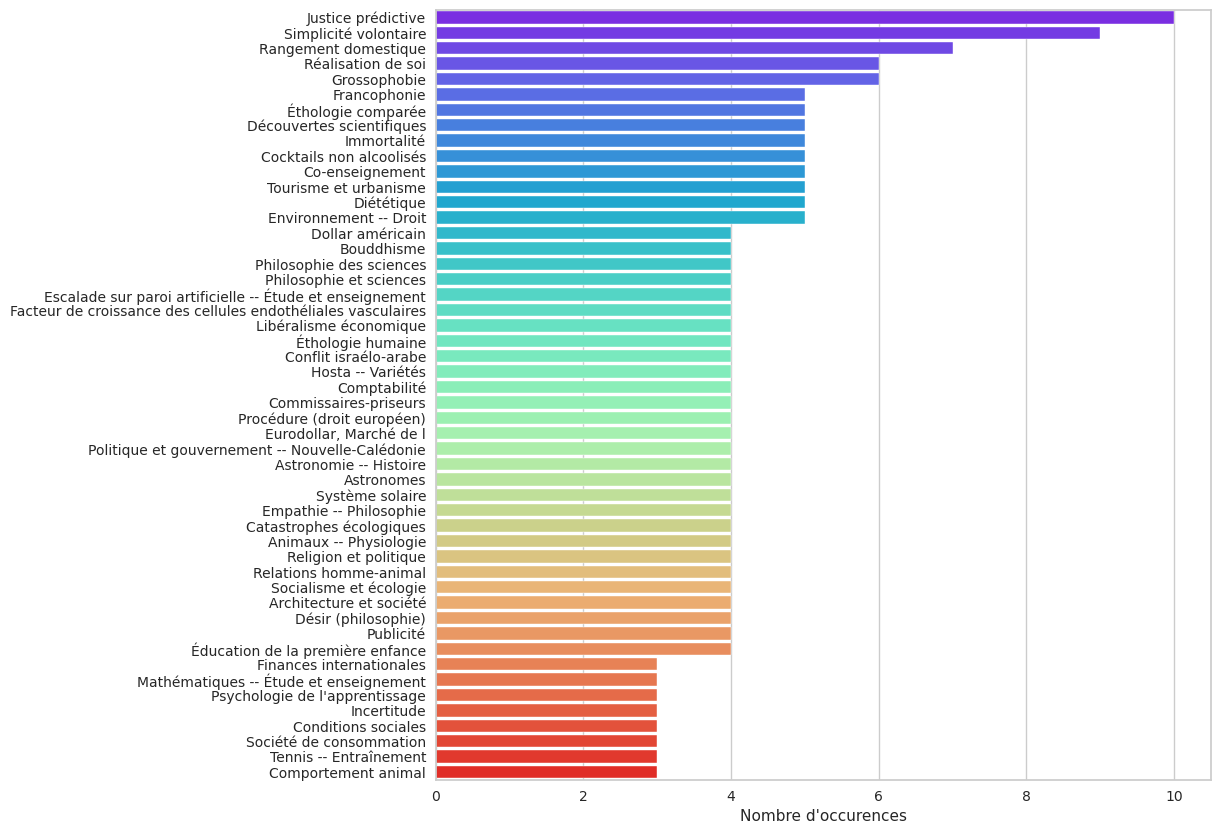

In [ ]:
plot_barplot_of_tags(
    index_chains2,
    nb_of_tags=50,
    xlabel="Nombre d'occurences",
    ylabel="",
    figsave="barplot_indexationChains_reindexation.png",
    figsize=(10, 10),
    palette="rainbow",
    orient="h",
)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

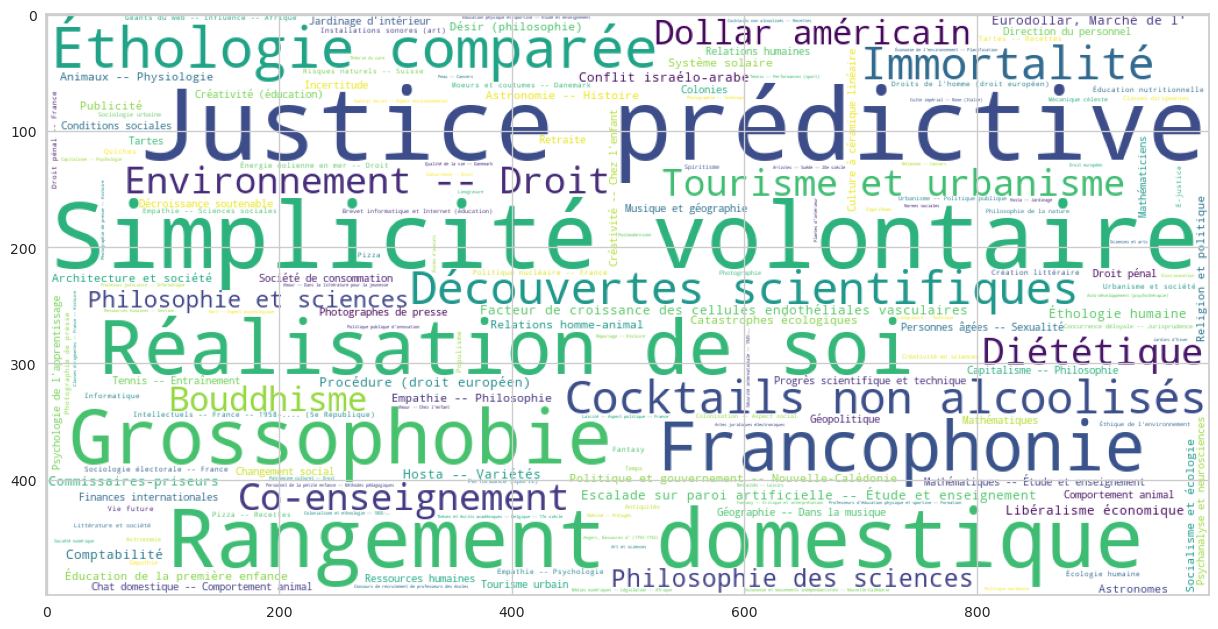

In [ ]:
plot_wordcloud(
    index_chains,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_index_chains_reindexation.png",
)

In [ ]:
df.head(2)

PPN                                              DESCR   
0  000308838  Les sommets de l'État : essai sur l'élite du p...  \
1  00094758X  Le dollar La quatrième de couverture indique :...   

                                      RAMEAU_CHECKED   
0  Bureaucratie;Classes dirigeantes;Classes dirig...  \
1  Dollar américain;Finances internationales;Poli...   

                                     rameau_concepts   
0  [Bureaucratie, Classes dirigeantes, Classes di...  \
1  [Dollar américain, Finances internationales, P...   

                                rameau_chaines_index   
0  [Bureaucratie, Classes dirigeantes, Classes di...  \
1  [Dollar américain, Finances internationales, P...   

                                           INDEX_AFE   
0  Classes dirigeantes -- France -- Histoire;;Pou...  \
1  Dollar américain;;Eurodollar, Marché de l';;Po...   

                                           INDEX_JMF   
0  Classes dirigeantes -- Relations avec l'État -...  \
1  Dollar américain ;;Politique économique -- Éta...   

                                           INDEX_LJZ   
0  Classes dirigeantes -- France;;Hauts-fonctionn...  \
1  Dollar américain;;Eurodollar, Marché de l';;Fi...   

                                           INDEX_LPL   
0  Hauts-fonctionnairesss -- France;;Classes diri...  \
1  Dollar américain -- Influence -- 20e siècle;;F...   

                                           INDEX_MCR   
0  Pouvoir (sciences sociales) -- Classes dirigea...  \
1  Dollar américain -- Mondialisation;;Dollar amé...   

                                           INDEX_MPD   
0  Classes dirigeantes -- France -- Histoire;;Éli...  \
1  Dollar américain;;Eurodollar, Marché de l';;Fi...   

                                       INDEX_UNI_AFE   
0  606$3027223345$aClasses dirigeantes$3027226794...  \
1  606$3027882691$aDollar américain\n606$30277420...   

                                       INDEX_UNI_JMF   
0  606$3027223345$aClasses dirigeantes$302779430X...  \
1  \n606$3027882691$aDollar américain \n606$30346...   

                                       INDEX_UNI_LJZ   
0  606$3027223345$aClasses dirigeantes$3027226794...  \
1  606$3027882691$aDollar américain\n606$30277420...   

                                       INDEX_UNI_LPL   
0  606$3027322610$aHauts-fonctionnairesss$3027226...  \
1  606‎$3027882691$aDollar américain‎$3027791246$...   

                                       INDEX_UNI_MCR   
0  606 $3027365581$aPouvoir (sciences sociales)$3...  \
1  606 $3027882691$aDollar américain$303500407X$x...   

                                       INDEX_UNI_MPD  N°ordre   
0  606$3027223345$aClasses dirigeantes$3027226794...       79  \
1  606$3027882691$aDollar américain\n606$30277420...       55   

                                  rameau_concept_AFE   
0  [Classes dirigeantes, France, Histoire, Pouvoi...  \
1  [Dollar américain, Eurodollar, Marché de l', P...   

                                  rameau_concept_MCR   
0  [Pouvoir (sciences sociales), Classes dirigean...  \
1  [Dollar américain, Mondialisation, Dollar amér...   

                                  rameau_concept_JMF   
0  [Classes dirigeantes, Relations avec l'État, F...  \
1  [Dollar américain , Politique économique, État...   

                                  rameau_concept_LPL   
0  [Hauts-fonctionnairesss, France, Classes dirig...  \
1  [Dollar américain, Influence, 20e siècle, Fina...   

                                  rameau_concept_LJZ   
0  [Classes dirigeantes, France, Hauts-fonctionna...  \
1  [Dollar américain, Eurodollar, Marché de l', F...   

                                  rameau_concept_MPD   
0  [Classes dirigeantes, France, Histoire, Élite ...  \
1  [Dollar américain, Eurodollar, Marché de l', F...   

                              rameau_index_chain_AFE   
0  [Classes dirigeantes -- France -- Histoire, Po...  \
1  [Dollar américain, Eurodollar, Marché de l', P...   

                              rameau_index_chain_MCR   
0  [Po

In [ ]:
# Save formatted dataframe
df.to_pkl(os.path.join(data_path, "reindexation_final_with_concepts_juin2023.pickle"))

In [111]:
# Binarization et vérification de l'encodage
mlb_chains = MultiLabelBinarizer(sparse_output=True)
index_chains_rameau = mlb_chains.fit_transform([index_chains]) # all indexation chains
mlb_chains.classes_

array(['Acceptation de soi', 'Actes juridiques électroniques',
       'Acteurs -- France', ..., 'Éthologie humaine',
       "Études d'impact (administration publique)",
       'Évolution du comportement'], dtype=object)

In [112]:
sudoc_chains = mlb_chains.transform(df["rameau_chaines_index"])
afe_chains = mlb_chains.transform(df["rameau_index_chain_AFE"])
mcr_chains = mlb_chains.transform(df["rameau_index_chain_MCR"])
jmf_chains = mlb_chains.transform(df["rameau_index_chain_JMF"])
lpl_chains = mlb_chains.transform(df["rameau_index_chain_LPL"])
ljz_chains = mlb_chains.transform(df["rameau_index_chain_LJZ"])
mpd_chains = mlb_chains.transform(df["rameau_index_chain_MPD"])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning:

unknown class(es) ['nan'] will be ignored



In [114]:
# Vérification de l'encodage
mlb_chains.inverse_transform(afe_chains)

[('Pouvoir communautaire -- France',
  'Classes dirigeantes -- France -- Histoire'),
 ('Dollar américain',
  "Eurodollar, Marché de l'",
  'Politique monétaire -- États-Unis'),
 ('Intellectuels -- France -- 1958-.... (5e République)',),
 ('Bouddhisme',),
 ('Mathématiques -- Étude et enseignement',
  "Psychologie de l'éducation",
  "Psychologie de l'apprentissage"),
 ('Philosophie et sciences',),
 ('Empereurs -- Rome (Italie)', 'Culte impérial -- Rome (Italie)'),
 ('Escalade sur paroi artificielle -- Étude et enseignement',
  'Escalade sur paroi artificielle -- Méthodes pédagogiques'),
 ('Brevet Informatique et Internet (pédagogie)', 'Informatique'),
 ('Énergie éolienne en mer -- Droit',
  'Éoliennes -- Aménagement',
  'Éoliennes -- Construction et conception'),
 ('Autonomie et mouvements indépendantistes -- Nouvelle-Calédonie',
  'Politique et gouvernement -- Nouvelle-Calédonie'),
 ('Francophonie',),
 ('Mélanome -- Cancers', 'Peau -- Cancers'),
 ('Système solaire', 'Astronomie -- Histo

In [115]:
# Compute metrics
from itertools import combinations

chains_list = [sudoc_chains, afe_chains, mcr_chains, jmf_chains, lpl_chains, ljz_chains, mpd_chains]
    
result_chains = dict()

for names, concept in zip(list(combinations(index_name, 2)), list(combinations(chains_list, 2))):
    print(f"comparing {names[0]} and  {names[1]}")
    name = str(names[0] + '-' + names[1])
    result_chains[name] = label_metrics_report("reindexation_chains", concept[0], concept[1], zero_division=0)

comparing sudoc and  afe
comparing sudoc and  mcr
comparing sudoc and  jmf
comparing sudoc and  lpl
comparing sudoc and  ljz
comparing sudoc and  mpd
comparing afe and  mcr
comparing afe and  jmf
comparing afe and  lpl
comparing afe and  ljz
comparing afe and  mpd
comparing mcr and  jmf
comparing mcr and  lpl
comparing mcr and  ljz
comparing mcr and  mpd
comparing jmf and  lpl
comparing jmf and  ljz
comparing jmf and  mpd
comparing lpl and  ljz
comparing lpl and  mpd
comparing ljz and  mpd


### Dataframe of results

In [116]:
result_chains_df = pd.DataFrame(result_chains).T
result_chains_df.head(3)

Hamming Loss Brier Loss Accuracy Precision - Macro Recall - Macro   
sudoc-afe     0.003288        NaN     0.03          0.021978       0.021978  \
sudoc-mcr      0.00317        NaN     0.03          0.010566       0.010566   
sudoc-jmf     0.003702        NaN     0.01           0.02226       0.022823   

          F1_Score - Macro Jaccard - Macro Precision - Weighted   
sudoc-afe         0.021978        0.021978             0.115385  \
sudoc-mcr         0.010425        0.010144             0.057692   
sudoc-jmf         0.022401         0.02226             0.116809   

          Recall - Weighted F1_Score - Weighted Jaccard - Weighted   
sudoc-afe          0.115385            0.115385           0.115385  \
sudoc-mcr          0.055556            0.055556           0.053419   
sudoc-jmf          0.119658            0.117521           0.116809   

          Precision - Sample Recall - Sample F1_Score - Sample   
sudoc-afe           0.153333        0.142929          0.136262  \
sudoc-mcr               0.08        0.081762          0.073357   
sudoc-jmf           0.113333        0.140095          0.114508   

          Jaccard - Sample                                          Precision   
sudoc-afe         0.102119  {'Macro': 0.02197802197802198, 'Micro': 0.1291...  \
sudoc-mcr         0.058762  {'Macro': 0.010566356720202874, 'Micro': 0.077...   
sudoc-jmf         0.079361  {'Macro': 0.022259791490560725, 'Micro': 0.107...   

                                                      Recall   
sudoc-afe  {'Macro': 0.02197802197802198, 'Micro': 0.1153...  \
sudoc-mcr  {'Macro': 0.010566356720202874, 'Micro': 0.055...   
sudoc-jmf  {'Macro': 0.02282333051563821, 'Micro': 0.1196...   

                                                  F1-measure   
sudoc-afe  {'Macro': 0.02197802197802198, 'Micro': 0.1218...  \
sudoc-mcr  {'Macro': 0.010425471963933501, 'Micro': 0.064...   
sudoc-jmf  {'Macro': 0.022400676246830092, 'Micro': 0.113...   

                                                     Jaccard  
sudoc-afe  {'Macro': 0.02197802197802198, 'Micro': 0.0649...  
sudoc-mcr  {'Macro': 0.01014370245139476, 'Micro': 0.0335...  
sudoc-jmf  {'Macro': 0.022259791490560725, 'Micro': 0.060...

### Plot

In [117]:
# Plot results
metrics_radar_plot(
    result_chains_df,
    metrics=metrics,
    remove_identity=True,
    title="Prédiction des chaines d'indexation",
    savefig="metrics_reindexation_Chains_raw.html",)

## Bag of words (tf-idf or CountVectorizer)

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### tfID vectorizer

In [54]:
def identity_tokenizer(text):
    return text
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, ngram_range=(1,3), lowercase=False)

In [55]:
# Vectorization
vectorised_concepts = vectorizer.fit_transform(labels)
autorites = vectorizer.get_feature_names_out()

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

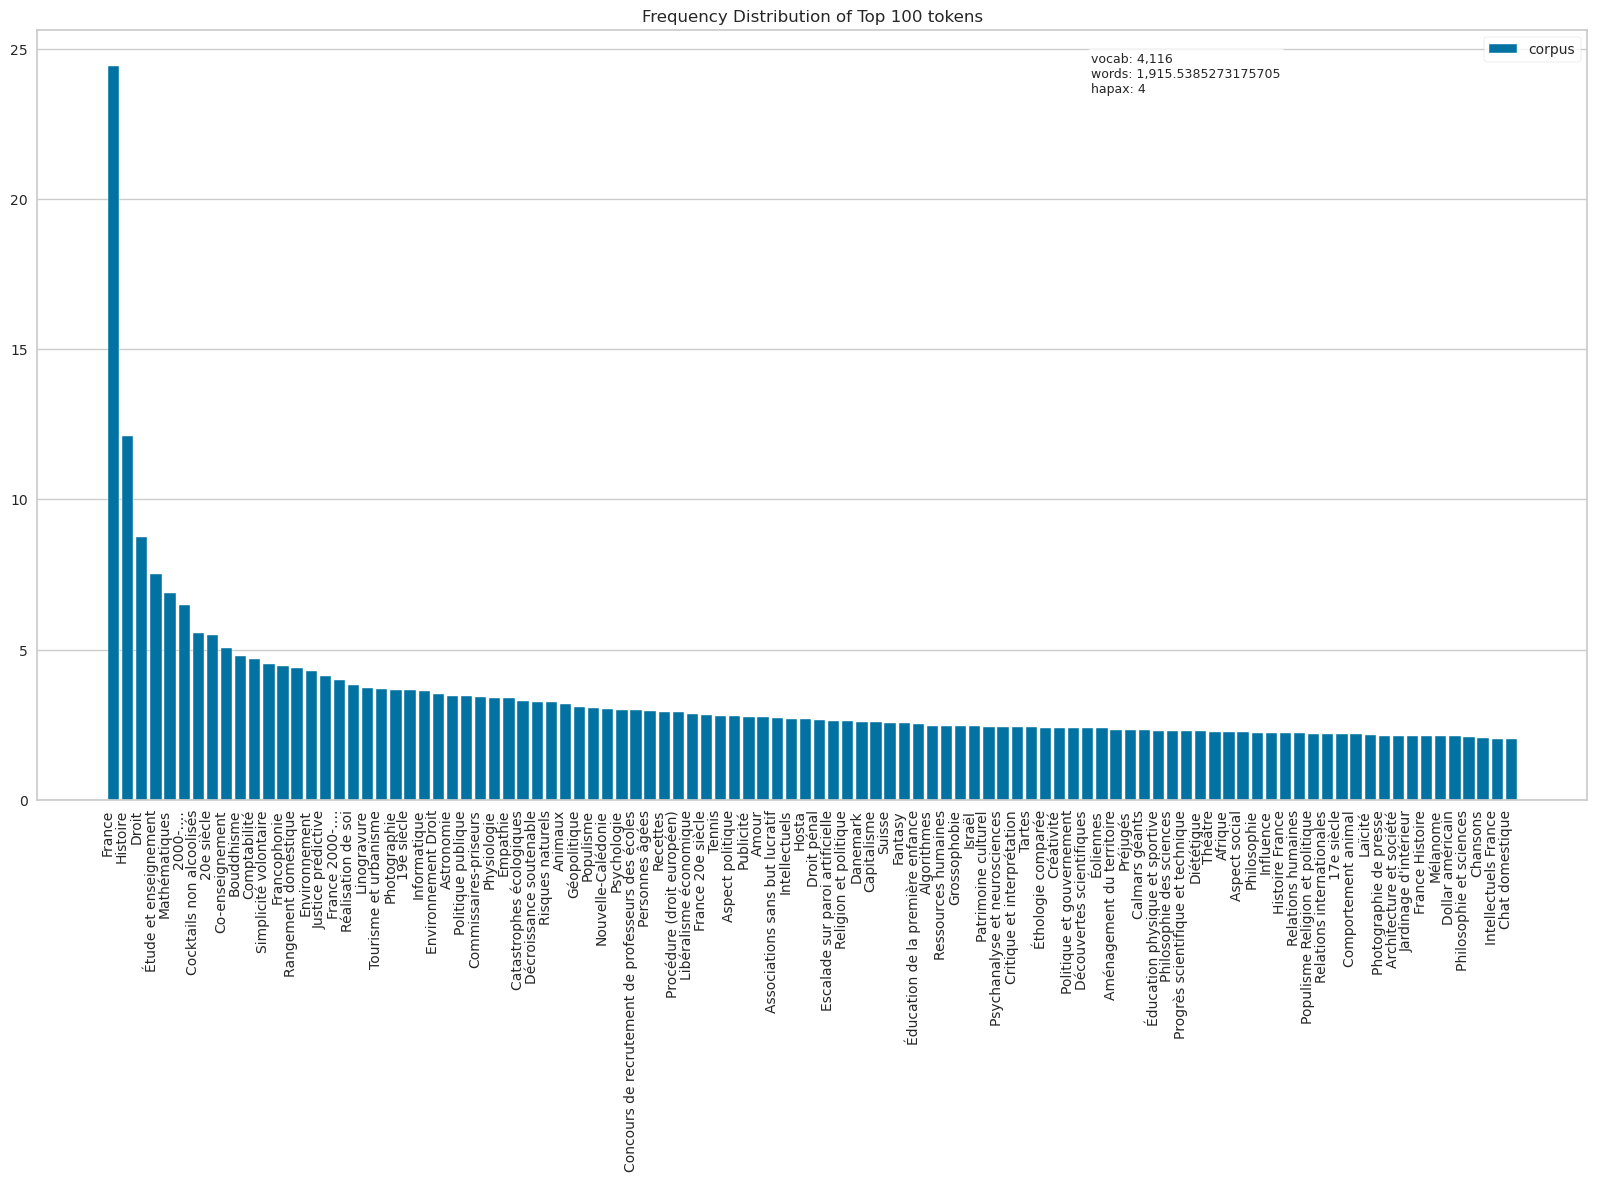

<Axes: title={'center': 'Frequency Distribution of Top 100 tokens'}>

In [56]:
from yellowbrick.text import FreqDistVisualizer
plt.figure(figsize=(20, 10))
features = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, n=100, orient="v")
visualizer.fit(vectorised_concepts)
visualizer.show()

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/yellowbrick/text/tsne.py:401: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

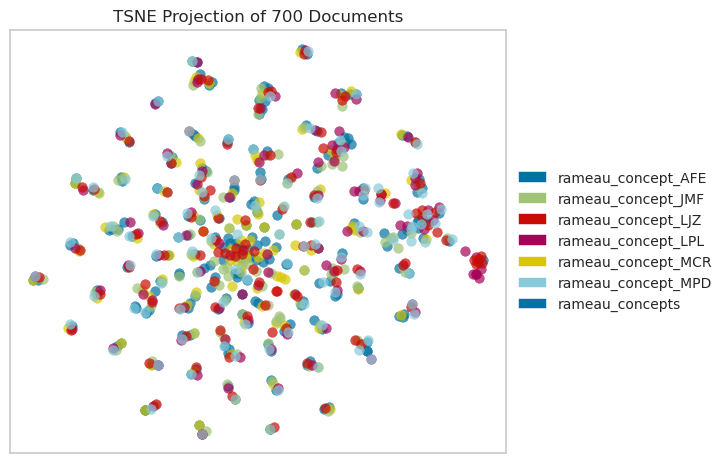

<Axes: title={'center': 'TSNE Projection of 700 Documents'}>

In [57]:
# Visualize the dataset with T-SNE
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(vectorised_concepts, df_pivot["variable"])
tsne.show()

### Count vectorizer

In [58]:
vectorizer = CountVectorizer(tokenizer=identity_tokenizer, ngram_range=(1,3), lowercase=False)
vectorised_concepts = vectorizer.fit_transform(df_pivot["value"])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [59]:
# Vectorization
vectorised_concepts = vectorizer.fit_transform(labels, df_pivot["variable"])
autorites = vectorizer.get_feature_names_out()

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/yellowbrick/text/tsne.py:401: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

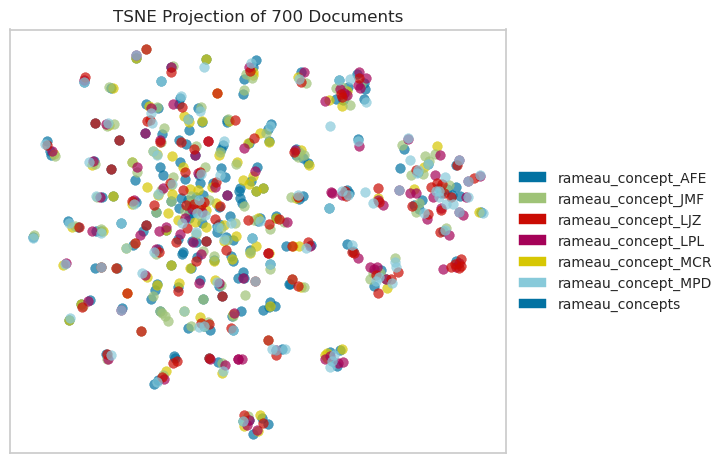

<Axes: title={'center': 'TSNE Projection of 700 Documents'}>

In [60]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(vectorised_concepts, df_pivot["variable"])
tsne.show()

## Test kmeans


In [62]:
# Select columns to use
concept_cols = [
    "rameau_concepts", "rameau_concept_AFE", "rameau_concept_MCR",
    "rameau_concept_JMF", "rameau_concept_LPL", "rameau_concept_LJZ",
    "rameau_concept_MPD"]
df_for_analysis = df[concept_cols]
labels_encoded = pd.DataFrame(mlb.fit_transform(flatten(df_pivot["value"])))

In [63]:
len(labels_encoded), len(labels_encoded[0])

(2717, 2717)

In [64]:
# Clustering based on Kmeans
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [65]:
# test different clusters
sil = []
davis_bouldin = []
sum_of_squared_distances = []
param_range = range(3,100)
for k in param_range:
    print(f"Clustering with {k} groups")
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(labels_encoded)
    labels = kmeans.labels_
    sum_of_squared_distances.append(kmeans.inertia_)
    silh = silhouette_score(
        labels_encoded, labels, metric="euclidean", sample_size=50000, random_state=200
        )
    dav = davies_bouldin_score(labels_encoded, labels)
    sil.append(silh)
    davis_bouldin.append(dav)

Clustering with 3 groups
Clustering with 4 groups
Clustering with 5 groups


Clustering with 6 groups
Clustering with 7 groups
Clustering with 8 groups
Clustering with 9 groups
Clustering with 10 groups
Clustering with 11 groups
Clustering with 12 groups
Clustering with 13 groups
Clustering with 14 groups
Clustering with 15 groups
Clustering with 16 groups
Clustering with 17 groups
Clustering with 18 groups
Clustering with 19 groups
Clustering with 20 groups
Clustering with 21 groups
Clustering with 22 groups
Clustering with 23 groups
Clustering with 24 groups
Clustering with 25 groups
Clustering with 26 groups
Clustering with 27 groups
Clustering with 28 groups
Clustering with 29 groups
Clustering with 30 groups
Clustering with 31 groups
Clustering with 32 groups
Clustering with 33 groups
Clustering with 34 groups
Clustering with 35 groups
Clustering with 36 groups
Clustering with 37 groups
Clustering with 38 groups
Clustering with 39 groups
Clustering with 40 groups
Clustering with 41 groups
Clustering with 42 groups
Clustering with 43 groups
Clustering with 

In [66]:
# Find optimal values accordin to silhouette and Davis-Bouldin scores
opt_val_sil = param_range[sil.index(max(sil))]
opt_val_db = param_range[davis_bouldin.index(min(davis_bouldin))]

In [67]:
def plot_metrics(
    sil, davis_bouldin, param_name, param_range, silhouette_color="red", db_color="blue"
):
    """
    Plot the silhouette score and davies_bouldin score for a range of cluster number.

    Parameters:
    -----------
        - sil (list): list of silhouette scores for all values of hyper-parameter range
        - davis_bouldin (list): list of davies-bouldin scores along hyper-parameter range
        - param_name (str): name of the hyper-parameter to be fined-tuned
        - param_range (list) : range of possible values for hyper-parameter tuning
        - silhouette_color (str): color for the silhouette score (defaut: 'red')
        - db_color (str): color for the silhouette score (defaut: 'blue')

    Returns :
    ---------
        - Evolution of silhouette and Davies-bouldin scores along hyper-parameter range
    """

    # plot
    _, ax1 = plt.subplots()
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Silhouette_score", color=silhouette_color)
    ax1.plot(param_range, sil, color=silhouette_color)
    ax1.tick_params(axis="y", labelcolor=silhouette_color)

    # Adding Twin Axes
    ax2 = ax1.twinx()
    ax2.set_ylabel("Davies_bouldin", color=db_color)
    ax2.plot(param_range, davis_bouldin, color=db_color)
    ax2.tick_params(axis="y", labelcolor=db_color)

    # Show plot
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

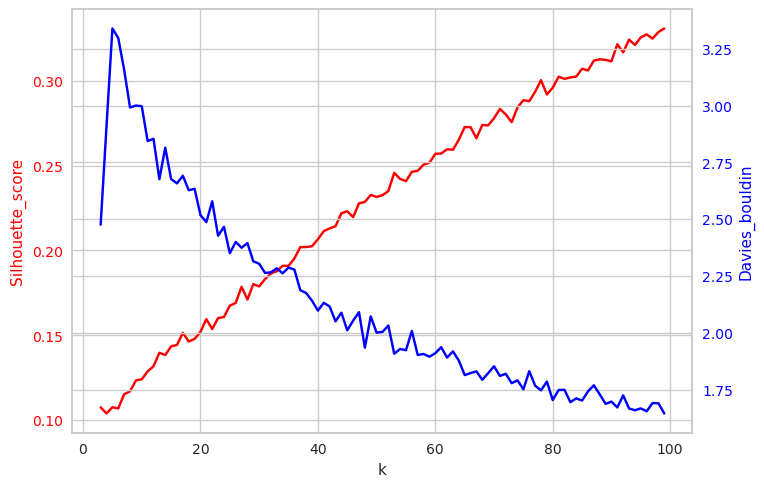

In [68]:
plot_metrics(sil, davis_bouldin, param_name="k", param_range=param_range, silhouette_color="red", db_color="blue")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

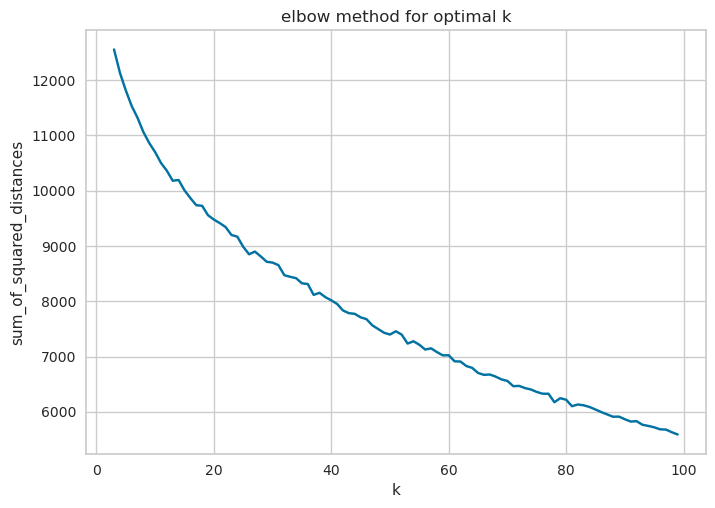

In [69]:
# Plot inertia
plt.plot(param_range, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [70]:
# Best clustering
#k = opt_val_sil
k = 59
kmeans = KMeans(n_clusters=k)
kmeans.fit(labels_encoded)

KMeans(n_clusters=59)

Graph des Silhouettes



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

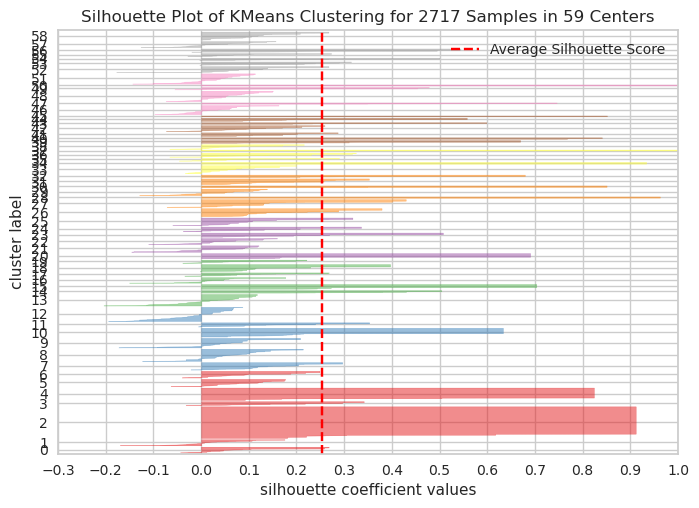

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2717 Samples in 59 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [71]:
# Graph des silhouettes
from yellowbrick.cluster import SilhouetteVisualizer
print("Graph des Silhouettes\n")
silhouette_vis = SilhouetteVisualizer(kmeans)
silhouette_vis.fit(labels_encoded)
silhouette_vis.poof()

In [72]:
# Plot clusters
# Fit visualisation pipeline
import sklearn
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(labels_encoded)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

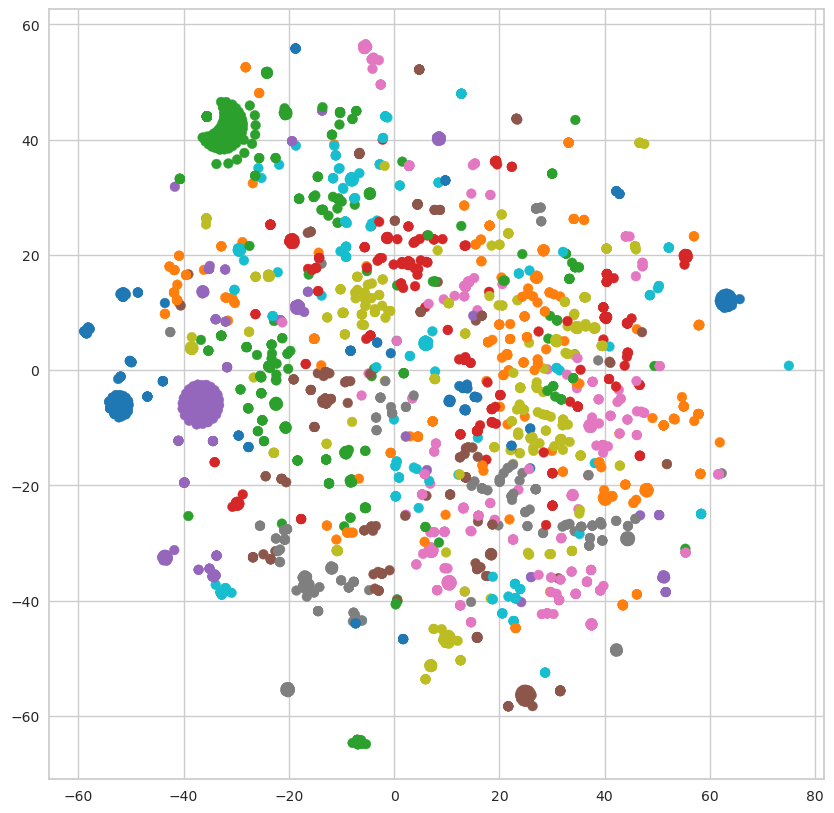

In [73]:
# Plot TSNE
plt.figure(figsize=(10, 10))
axe = plt.axes()
clusters = kmeans.labels_
num_classes = k
palette = np.array(sns.color_palette("tab10", num_classes))
axe.scatter(x=tsne[:, 0], y=tsne[:, 1], c=palette[clusters.astype(int)])
plt.legend()